# vLife Virtusa

# MANAGING THE SUPPLY CHAIN
## Freight Cost Prediction Usecase

### Usecase Description

### Predicting Freight cost of Shipment of Medications across different Vendors
 - The supply chain is one of a provider’s largest cost centers, and represents one of the most significant opportunities for healthcare organizations to trim unnecessary spending and improve efficiency.

 - Predictive tools are in high demand among hospital executives looking to reduce variation and gain more actionable insights into ordering patterns and supply utilization.

 - Only 17 percent of hospitals currently use automated or data-driven solutions to manage their supply chains, said Cardinal Health in 2017. 

 - In the same year, Global Healthcare Exchange ranked predictive analytics for supply chain management as the number one item on the executive wish list – a follow-up survey in 2018 found that adopting data analytics tools remained a top priority.

 - Using analytics tools to monitor the supply chain and make proactive, data-driven decisions about spending could save hospitals almost $10 million per year, a separate Navigant survey added.  Both descriptive and predictive analytics can support decisions to negotiate pricing, reduce the variation in supplies, and optimizing the ordering process

### Data Source 
Data for this Usecase can be found [here](https://www.kaggle.com/divyeshardeshana/supply-chain-shipment-pricing-data)

### Dataset Description
 - Project Code
 - PQ #
 - PO / SO #
 - ASN/DN #
 - Country
 - Managed By
 -  Fulfill Via
 -  Vendor INCO Term
 - Shipment Mode
 - PQ First Sent to Client Date
 - PO Sent to Vendor Date
 - Scheduled Delivery Date
 - Delivered to Client Date
 - Delivery Recorded Date
 - Product Group
 - Sub Classification
 - Vendor
 - Item Description
 - Molecule/Test Type
 - Brand
 - Dosage
 - Dosage Form
 - Unit of Measure (Per Pack)
 - Line Item Quantity
 - Line Item Value
 - Pack Price
 - Unit Price
 - Manufacturing Site
 - First Line Designation
 - Weight (Kilograms)
 - Freight Cost (USD)
 - Line Item Insurance (USD)

### Import Neccessary Packages and Libraries

In [158]:
import numpy as np 
import pandas as pd 
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from datetime import datetime

from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error,make_scorer,r2_score
from sklearn.inspection import plot_partial_dependence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.linear_model import Lasso, Ridge, SGDRegressor,LinearRegression,RidgeCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,Imputer
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor,DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

import warnings
import pprint

import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

pd.set_option('max_columns', 200)

In [159]:
df = pd.read_csv('../input/supply-chain-shipment-pricing-data/SCMS_Delivery_History_Dataset.csv')

### Data Munging

In [160]:
print('Shape of Dataset {}'.format(df.shape))

Shape of Dataset (10324, 33)


In [161]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [162]:
df.head()

,id,project_code,pq_#,po_/_so_#,asn/dn_#,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,pq_first_sent_to_client_date,po_sent_to_vendor_date,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,product_group,sub_classification,vendor,item_description,molecule/test_type,brand,dosage,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [163]:
df['scheduled_delivery_date'] = pd.to_datetime(df['scheduled_delivery_date'])
df['delivered_to_client_date'] = pd.to_datetime(df['delivered_to_client_date'])
df['delivery_recorded_date'] = pd.to_datetime(df['delivery_recorded_date'])

In [164]:
print(list(df.columns))

['id', 'project_code', 'pq_#', 'po_/_so_#', 'asn/dn_#', 'country', 'managed_by', 'fulfill_via', 'vendor_inco_term', 'shipment_mode', 'pq_first_sent_to_client_date', 'po_sent_to_vendor_date', 'scheduled_delivery_date', 'delivered_to_client_date', 'delivery_recorded_date', 'product_group', 'sub_classification', 'vendor', 'item_description', 'molecule/test_type', 'brand', 'dosage', 'dosage_form', 'unit_of_measure_per_pack', 'line_item_quantity', 'line_item_value', 'pack_price', 'unit_price', 'manufacturing_site', 'first_line_designation', 'weight_kilograms', 'freight_cost_usd', 'line_item_insurance_usd']


### Exploratory Data Analysis

In [165]:
null_feat = pd.DataFrame(len(df['id']) - df.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'red',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [166]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [167]:
missing_data(df)

,id,project_code,pq_#,po_/_so_#,asn/dn_#,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,pq_first_sent_to_client_date,po_sent_to_vendor_date,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,product_group,sub_classification,vendor,item_description,molecule/test_type,brand,dosage,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd
Total,0,0,0,0,0,0,0,0,0,360,0,0,0,0,0,0,0,0,0,0,0,1736,0,0,0,0,0,0,0,0,0,0,287
Percent,0,0,0,0,0,0,0,0,0,3.48702,0,0,0,0,0,0,0,0,0,0,0,16.8152,0,0,0,0,0,0,0,0,0,0,2.77993
Types,int64,object,object,object,object,object,object,object,object,object,object,object,datetime64[ns],datetime64[ns],datetime64[ns],object,object,object,object,object,object,object,object,int64,int64,float64,float64,float64,object,object,object,object,float64


In [168]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [169]:
unique_values(df)

,id,project_code,pq_#,po_/_so_#,asn/dn_#,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,pq_first_sent_to_client_date,po_sent_to_vendor_date,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,product_group,sub_classification,vendor,item_description,molecule/test_type,brand,dosage,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd
Total,10324,10324,10324,10324,10324,10324,10324,10324,10324,9964,10324,10324,10324,10324,10324,10324,10324,10324,10324,10324,10324,8588,10324,10324,10324,10324,10324,10324,10324,10324,10324,10324,10037
Uniques,10324,142,1237,6233,7030,43,4,2,8,4,765,897,2006,2093,2042,5,6,73,184,86,48,54,17,31,5065,8741,1175,183,88,2,4688,6733,6722


In [170]:
for column in df.columns.values:
    print(f" Unique values of {column} : {df[column].nunique()}")

 Unique values of id : 10324
 Unique values of project_code : 142
 Unique values of pq_# : 1237
 Unique values of po_/_so_# : 6233
 Unique values of asn/dn_# : 7030
 Unique values of country : 43
 Unique values of managed_by : 4
 Unique values of fulfill_via : 2
 Unique values of vendor_inco_term : 8
 Unique values of shipment_mode : 4
 Unique values of pq_first_sent_to_client_date : 765
 Unique values of po_sent_to_vendor_date : 897
 Unique values of scheduled_delivery_date : 2006
 Unique values of delivered_to_client_date : 2093
 Unique values of delivery_recorded_date : 2042
 Unique values of product_group : 5
 Unique values of sub_classification : 6
 Unique values of vendor : 73
 Unique values of item_description : 184
 Unique values of molecule/test_type : 86
 Unique values of brand : 48
 Unique values of dosage : 54
 Unique values of dosage_form : 17
 Unique values of unit_of_measure_per_pack : 31
 Unique values of line_item_quantity : 5065
 Unique values of line_item_value : 874

In [171]:
df.dtypes

id                                       int64
project_code                            object
pq_#                                    object
po_/_so_#                               object
asn/dn_#                                object
country                                 object
managed_by                              object
fulfill_via                             object
vendor_inco_term                        object
shipment_mode                           object
pq_first_sent_to_client_date            object
po_sent_to_vendor_date                  object
scheduled_delivery_date         datetime64[ns]
delivered_to_client_date        datetime64[ns]
delivery_recorded_date          datetime64[ns]
product_group                           object
sub_classification                      object
vendor                                  object
item_description                        object
molecule/test_type                      object
brand                                   object
dosage       

In [172]:
for col in df.select_dtypes(include=np.number):
    df[col] = df[col].fillna(df[col].median())

In [173]:
from sklearn_pandas import CategoricalImputer
imputer = CategoricalImputer()
for i in range(0,df.shape[1]):
    if df.dtypes[i]=='object':
        df[df.columns[i]] = imputer.fit_transform(df[df.columns[i]])


In [174]:
df.apply(lambda x :sum(x.isnull()))

id                              0
project_code                    0
pq_#                            0
po_/_so_#                       0
asn/dn_#                        0
country                         0
managed_by                      0
fulfill_via                     0
vendor_inco_term                0
shipment_mode                   0
pq_first_sent_to_client_date    0
po_sent_to_vendor_date          0
scheduled_delivery_date         0
delivered_to_client_date        0
delivery_recorded_date          0
product_group                   0
sub_classification              0
vendor                          0
item_description                0
molecule/test_type              0
brand                           0
dosage                          0
dosage_form                     0
unit_of_measure_per_pack        0
line_item_quantity              0
line_item_value                 0
pack_price                      0
unit_price                      0
manufacturing_site              0
first_line_des

In [175]:
data = df.copy()

In [176]:
data.head()

,id,project_code,pq_#,po_/_so_#,asn/dn_#,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,pq_first_sent_to_client_date,po_sent_to_vendor_date,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,product_group,sub_classification,vendor,item_description,molecule/test_type,brand,dosage,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2006-06-02,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,300mg,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,47.04
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2006-11-14,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,47.04
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,2006-08-27,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,300mg,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,47.04
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2006-09-01,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,47.04
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2006-08-11,2006-08-11,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,47.04


In [177]:
M = data[(data['sub_classification'] == 'Adult')]
B = data[(data['sub_classification'] == 'Pediatric')]
S = data[(data['sub_classification'] == 'HIV test')]
K = data[(data['sub_classification'] == 'HIV test - Ancillary')]
L = data[(data['sub_classification'] == 'Malaria')]
P = data[(data['sub_classification'] == 'ACT')]

trace = go.Bar(y = (len(M), len(B),len(S),len(K),len(L),len(P)), x = ['Adult','Pediatric','HIV test','HIV test - Ancillary','Malaria','ACT'], orientation = 'v',opacity = 0.8, marker=dict(
        color=['green','red','blue','grey','yellow','violet'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of Sub Classification variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [178]:
F=data['shipment_mode'].value_counts().sort_values(ascending=False)[:15]
label=F.index
size=F.values
colors = ['skyblue', '#FEBFB3', '#96D38C', '#D0F9B1', 'gold', 'orange', 'lightgrey', 
          'lightblue','lightgreen','aqua','yellow','#D4E157','#D1C4E9','#1A237E','#64B5F6','#009688',
          '#1DE9B6','#66BB6A','#689F38','#FFB300']
trace =go.Pie(labels=label, values=size, marker=dict(colors=colors), hole=.1)
data_trace = [trace]
layout = go.Layout(title='Distribution of Shipment Mode')
fig=go.Figure(data=data_trace,layout=layout)
py.iplot(fig)

In [179]:
F=data['manufacturing_site'].value_counts().sort_values(ascending=False)[:8]
trace1 = go.Scatter(x=F.index, y=F.values,name='Top Manufacturing Site',marker=dict(color='green'))

F=data['manufacturing_site'].value_counts().sort_values(ascending=True)[:7].iloc[::-1]
trace2 = go.Scatter(x=F.index, y=F.values,name='Least Manufacturing Site ',marker=dict(color='red'))

data_trace=[trace1,trace2]
layout = dict(title = 'Freight Cost Distribution')
fig = dict(data=data_trace,layout = layout)
py.iplot(fig)

In [180]:
#TotalPrice = data.groupby(['Country'])['Pack Price'].sum().nlargest(15)
F=data.groupby('country').pack_price.sum().to_frame().sort_values(by='pack_price', ascending=False).round(3)
trace=go.Bar(x=F.index, y=F.pack_price, marker=dict(color = F.pack_price, colorscale='Cividis',showscale=True))
ddata=[trace]
layout = go.Layout(xaxis=dict(tickangle=45),title='Pack Price Country wise', yaxis = dict(title = 'Count'))
fig = go.Figure(data=ddata, layout=layout)
py.iplot(fig)

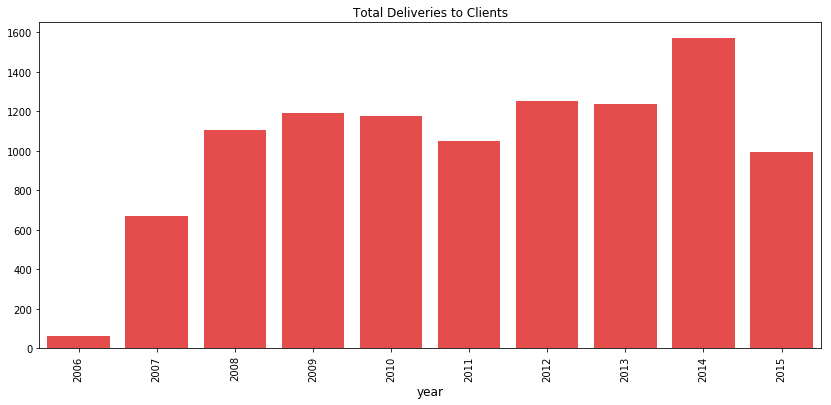

In [181]:
cnt_srs = data['delivered_to_client_date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='red')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Total Deliveries to Clients")
plt.show()

In [182]:
F=data.fulfill_via.value_counts().sort_values(ascending=False)[:15]

trace1 = go.Bar(x=F.index,y=F.values,marker=dict(color = '#009688'))
                                                      
F = data.shipment_mode.value_counts().sort_values(ascending=False)[:15]

trace2 = go.Bar(x=F.index, y=F.values, marker=dict( color ='#689F38' ))
 
fig = make_subplots(rows=1, cols=2, subplot_titles=('Fullfillment Details','Shipment Modes'))                                                        
 
fig.add_trace(trace1, 1,1) 
fig.add_trace(trace2, 1,2)  
fig['layout'].update(yaxis = dict(title = 'Values'), height=500, width=900, showlegend=False)
py.iplot(fig)

In [183]:

print("Unique Values in `freight_cost_usd` => {}".format(np.sort(data.freight_cost_usd.unique())))

print("Unique Values in `Age` => {}".format(np.sort(data.fulfill_via.unique())))
print("Unique Values in `country` => {}".format(np.sort(data.country.unique())))
print("Unique Values in `managed_by` => {}".format(np.sort(data.managed_by.unique())))
print("Unique Values in `vendor_inco_term` => {}".format(np.sort(data.vendor_inco_term.unique())))
print("Unique Values in `shipment_mode` => {}".format(np.sort(data.shipment_mode.unique())))
print("Unique Values in `product_group` => {}".format(np.sort(data.product_group.unique())))

Unique Values in `freight_cost_usd` => ['0.75' '1000.05' '1000.51' ... 'See DN-992 (ID#:11602)'
 'See DN-993 (ID#:11919)' 'See DN-998 (ID#:11568)']
Unique Values in `Age` => ['Direct Drop' 'From RDC']
Unique Values in `country` => ['Afghanistan' 'Angola' 'Belize' 'Benin' 'Botswana' 'Burkina Faso'
 'Burundi' 'Cameroon' 'Congo, DRC' "Côte d'Ivoire" 'Dominican Republic'
 'Ethiopia' 'Ghana' 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Kazakhstan'
 'Kenya' 'Kyrgyzstan' 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Malawi'
 'Mali' 'Mozambique' 'Namibia' 'Nigeria' 'Pakistan' 'Rwanda' 'Senegal'
 'Sierra Leone' 'South Africa' 'South Sudan' 'Sudan' 'Swaziland'
 'Tanzania' 'Togo' 'Uganda' 'Vietnam' 'Zambia' 'Zimbabwe']
Unique Values in `managed_by` => ['Ethiopia Field Office' 'Haiti Field Office' 'PMO - US'
 'South Africa Field Office']
Unique Values in `vendor_inco_term` => ['CIF' 'CIP' 'DAP' 'DDP' 'DDU' 'EXW' 'FCA' 'N/A - From RDC']
Unique Values in `shipment_mode` => ['Air' 'Air Charter' 'Ocean' 'Truck']
U

In [184]:
data.loc[df['freight_cost_usd'].str.contains('See'), 'freight_cost_usd'] = np.NaN
data.loc[df['freight_cost_usd'].str.contains('Freight'), 'freight_cost_usd'] = np.NaN
data.loc[df['freight_cost_usd'].str.contains('Invoiced'), 'freight_cost_usd'] = np.NaN

In [185]:
data['freight_cost_usd'] = pd.to_numeric(data['freight_cost_usd'], errors='coerce').fillna(0, downcast='infer')
data['freight_cost_usd'] = data['freight_cost_usd'].replace(0,data['freight_cost_usd'].median())

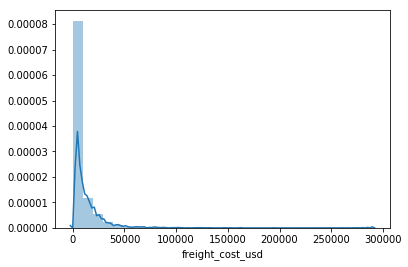

In [186]:
sns.distplot(data['freight_cost_usd'],bins=30)

### Feature Engineering

In [187]:
data.loc[df['weight_kilograms'].str.contains('Weight'), 'weight_kilograms'] = np.NaN
data.loc[df['weight_kilograms'].str.contains('See'), 'weight_kilograms'] = np.NaN
data['weight_kilograms'] = pd.to_numeric(data['weight_kilograms'], errors='coerce').fillna(0, downcast='infer')
data['weight_kilograms'] = data['weight_kilograms'].replace(0,data['freight_cost_usd'].median())

In [188]:
data.dtypes

id                                       int64
project_code                            object
pq_#                                    object
po_/_so_#                               object
asn/dn_#                                object
country                                 object
managed_by                              object
fulfill_via                             object
vendor_inco_term                        object
shipment_mode                           object
pq_first_sent_to_client_date            object
po_sent_to_vendor_date                  object
scheduled_delivery_date         datetime64[ns]
delivered_to_client_date        datetime64[ns]
delivery_recorded_date          datetime64[ns]
product_group                           object
sub_classification                      object
vendor                                  object
item_description                        object
molecule/test_type                      object
brand                                   object
dosage       

In [189]:
data['dosage'] = data['dosage'].map(lambda x: x.lstrip('mg/').rstrip('mg'))
data['dosage'] = data['dosage'].map(lambda x: x.rstrip('mg/ml'))

In [191]:
df_ = data[['id','molecule/test_type','dosage']]

In [192]:
df_['moleculeValues']=df_.apply(lambda x: x['molecule/test_type'].replace('/','!') if(x['dosage'].find('/')) else x['molecule/test_type'],axis=1)
df_['dosageValues']=df_.apply(lambda x: x['dosage'].replace('/','!') if(x['dosage'].find('/')) else x['dosage'],axis=1)

In [193]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [194]:
df_.drop(['molecule/test_type','dosage'],axis=1,inplace = True)

In [195]:
cleaned_df = splitDataFrameList(df_,'moleculeValues','!')

In [196]:
clean_df = splitDataFrameList(cleaned_df,'dosageValues','!')

In [197]:
clean_df['dosageValues']=clean_df['dosageValues'].replace('50+153','203')
clean_df['dosageValues']=clean_df['dosageValues'].replace('300mg+600','900')
clean_df['dosageValues']=clean_df['dosageValues'].replace('600mg','600')
clean_df['dosageValues']=clean_df['dosageValues'].replace('300+200','500')
clean_df['dosageValues']=clean_df['dosageValues'].replace('300+300','600')

In [198]:
mapping = {'HIV, Reveal G3 Rapid HIV-1 Antibody Test':'Rapid HIV Antibody Test','2 Antibody Kit,':'Antibody Kit','Malaria, Antigen P.f., HRP2 CareStart Kit':'Malaria Antigen','2, Visitect Kit':'Visitect Kit','2, INSTI HIV 1':'INSRI_HIV','Mefloquine (as hydrochloride)':'Mefloquine','Quinine (as sulfate)':'Quinine','2, ImmunoComb II BiSpot EIA Kit':'ImmunoComb II BiSpot EIA Kit','2, Colloidal Gold, Diagnostic Kit Set (includes lancet, transfer pipette & alcohol prep pad)':'Diagnostic Kit Set','2, Determine Complete HIV Kit':'Complete HIV Kit'}

In [199]:
clean_df['moleculeValues']=clean_df['moleculeValues'].replace(mapping)

In [200]:
preprocessed_data = pd.merge(clean_df,data,on = 'id').drop(['molecule/test_type','dosage','project_code','pq_#','po_/_so_#','asn/dn_#','vendor_inco_term','pq_first_sent_to_client_date','po_sent_to_vendor_date','item_description','managed_by'],axis=1)

In [201]:
preprocessed_data

,id,moleculeValues,dosageValues,country,fulfill_via,shipment_mode,scheduled_delivery_date,delivered_to_client_date,delivery_recorded_date,product_group,sub_classification,vendor,brand,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd
0,1,Rapid HIV Antibody Test,300,Côte d'Ivoire,Direct Drop,Air,2006-06-02,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,Reveal,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13.000,780.34,47.04
1,3,Nevirapine,10,Vietnam,Direct Drop,Air,2006-11-14,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,Generic,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358.000,4521.50,47.04
2,4,HIV 1,300,Côte d'Ivoire,Direct Drop,Air,2006-08-27,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,Determine,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.000,1653.78,47.04
3,4,Complete HIV Kit,300,Côte d'Ivoire,Direct Drop,Air,2006-08-27,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,Determine,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.000,1653.78,47.04
4,15,Lamivudine,150,Vietnam,Direct Drop,Air,2006-09-01,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Generic,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855.000,16007.06,47.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,86822,Zidovudine,300,Zimbabwe,From RDC,Truck,2015-09-09,2015-08-04,2015-08-11,ARV,Adult,SCMS from RDC,Generic,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392.000,1422.09,134.03
30252,86823,Lamivudine,30,Zimbabwe,From RDC,Truck,2015-08-31,2015-08-04,2015-08-11,ARV,Pediatric,SCMS from RDC,Generic,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,1422.205,1422.09,85.82
30253,86823,Lamivudine,60,Zimbabwe,From RDC,Truck,2015-08-31,2015-08-04,2015-08-11,ARV,Pediatric,SCMS from RDC,Generic,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,1422.205,1422.09,85.82
30254,86823,Zidovudine,30,Zimbabwe,From RDC,Truck,2015-08-31,2015-08-04,2015-08-11,ARV,Pediatric,SCMS from RDC,Generic,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,1422.205,1422.09,85.82


### Feature Extraction - (Numerical & Categorical Features)

In [202]:
preprocessed_data['Waiting_Time_days'] = preprocessed_data['scheduled_delivery_date'] - preprocessed_data['delivery_recorded_date']
preprocessed_data['Waiting_Time_days'] = preprocessed_data['Waiting_Time_days'].dt.days
preprocessed_data['ScheduleDelivery_Y'] = preprocessed_data['scheduled_delivery_date'].dt.year
preprocessed_data['ScheduleDelivery_M'] = preprocessed_data['scheduled_delivery_date'].dt.month
preprocessed_data['ScheduleDelivery_D'] = preprocessed_data['scheduled_delivery_date'].dt.day
preprocessed_data.drop(['scheduled_delivery_date'], axis=1, inplace=True)

preprocessed_data['delivered_to_client_date_Y'] = preprocessed_data['delivered_to_client_date'].dt.year
preprocessed_data['delivered_to_client_date_M'] = preprocessed_data['delivered_to_client_date'].dt.month
preprocessed_data['delivered_to_client_date_D'] = preprocessed_data['delivered_to_client_date'].dt.day
preprocessed_data.drop(['delivered_to_client_date'], axis=1, inplace=True)

preprocessed_data['delivery_recorded_date_Y'] = preprocessed_data['delivery_recorded_date'].dt.year
preprocessed_data['delivery_recorded_date_M'] = preprocessed_data['delivery_recorded_date'].dt.month
preprocessed_data['delivery_recorded_date_M'] = preprocessed_data['delivery_recorded_date'].dt.day
preprocessed_data.drop(['id','delivery_recorded_date'], axis=1, inplace=True)

In [203]:
preprocessed_data

,moleculeValues,dosageValues,country,fulfill_via,shipment_mode,product_group,sub_classification,vendor,brand,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd,Waiting_Time_days,ScheduleDelivery_Y,ScheduleDelivery_M,ScheduleDelivery_D,delivered_to_client_date_Y,delivered_to_client_date_M,delivered_to_client_date_D,delivery_recorded_date_Y,delivery_recorded_date_M
0,Rapid HIV Antibody Test,300,Côte d'Ivoire,Direct Drop,Air,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,Reveal,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13.000,780.34,47.04,0,2006,6,2,2006,6,2,2006,2
1,Nevirapine,10,Vietnam,Direct Drop,Air,ARV,Pediatric,Aurobindo Pharma Limited,Generic,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358.000,4521.50,47.04,0,2006,11,14,2006,11,14,2006,14
2,HIV 1,300,Côte d'Ivoire,Direct Drop,Air,HRDT,HIV test,Abbott GmbH & Co. KG,Determine,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.000,1653.78,47.04,0,2006,8,27,2006,8,27,2006,27
3,Complete HIV Kit,300,Côte d'Ivoire,Direct Drop,Air,HRDT,HIV test,Abbott GmbH & Co. KG,Determine,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.000,1653.78,47.04,0,2006,8,27,2006,8,27,2006,27
4,Lamivudine,150,Vietnam,Direct Drop,Air,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Generic,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855.000,16007.06,47.04,0,2006,9,1,2006,9,1,2006,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,Zidovudine,300,Zimbabwe,From RDC,Truck,ARV,Adult,SCMS from RDC,Generic,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392.000,1422.09,134.03,29,2015,9,9,2015,8,4,2015,11
30252,Lamivudine,30,Zimbabwe,From RDC,Truck,ARV,Pediatric,SCMS from RDC,Generic,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,1422.205,1422.09,85.82,20,2015,8,31,2015,8,4,2015,11
30253,Lamivudine,60,Zimbabwe,From RDC,Truck,ARV,Pediatric,SCMS from RDC,Generic,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,1422.205,1422.09,85.82,20,2015,8,31,2015,8,4,2015,11
30254,Zidovudine,30,Zimbabwe,From RDC,Truck,ARV,Pediatric,SCMS from RDC,Generic,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,1422.205,1422.09,85.82,20,2015,8,31,2015,8,4,2015,11


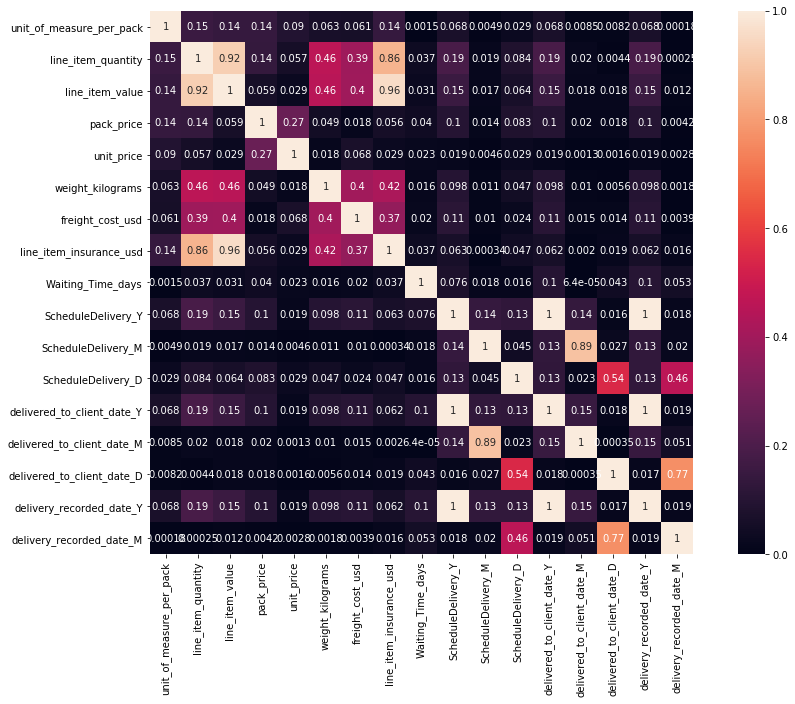

In [204]:
plt.figure(figsize=(16, 10))
ax = sns.heatmap(preprocessed_data.corr(method='pearson').abs(), annot=True, square=True)
plt.show()

In [205]:
preprocessed_data.dtypes

moleculeValues                 object
dosageValues                   object
country                        object
fulfill_via                    object
shipment_mode                  object
product_group                  object
sub_classification             object
vendor                         object
brand                          object
dosage_form                    object
unit_of_measure_per_pack        int64
line_item_quantity              int64
line_item_value               float64
pack_price                    float64
unit_price                    float64
manufacturing_site             object
first_line_designation         object
weight_kilograms              float64
freight_cost_usd              float64
line_item_insurance_usd       float64
Waiting_Time_days               int64
ScheduleDelivery_Y              int64
ScheduleDelivery_M              int64
ScheduleDelivery_D              int64
delivered_to_client_date_Y      int64
delivered_to_client_date_M      int64
delivered_to

## Prediction Models without One hot Encoding

In [206]:
preprocessed_data_with_ohe = preprocessed_data.copy()
preprocessed_data_with_vif = preprocessed_data.copy(deep=False)

In [207]:
le = LabelEncoder()
for i in range(0,preprocessed_data.shape[1]):
    if preprocessed_data.dtypes[i]=='object':
        preprocessed_data[preprocessed_data.columns[i]] = le.fit_transform(preprocessed_data[preprocessed_data.columns[i]])

In [208]:
# Def X and Y
y = np.array(preprocessed_data.freight_cost_usd)
preprocessed_data = preprocessed_data.drop('freight_cost_usd', 1)
X = np.array(preprocessed_data.as_matrix())

random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [209]:
scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)

In [210]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train_, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test_, y_test, scoring = scorer, cv = 10))
    return(rmse)

### Model Selection

In [211]:
clfs = []
seed = 3

clfs.append(("LinearRegression", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LinearRegression())])))

clfs.append(("XGB",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBRegressor())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsRegressor())]))) 

clfs.append(("DTR", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeRegressor())]))) 

clfs.append(("RFRegressor", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestRegressor())]))) 

clfs.append(("GBRegressor", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingRegressor(max_features=15, 
                                                                       n_estimators=600))]))) 

clfs.append(("MLP", 
             Pipeline([("Scaler", StandardScaler()),
                       ("MLP Regressor", MLPRegressor())])))


clfs.append(("EXT Regressor",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreeRegressor())])))
clfs.append(("SV Regressor",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", SVR())])))

scoring = 'r2'
n_folds = 10
msgs = []
results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv=kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    msgs.append(msg)
    print(msg)

LinearRegression: 0.302006 (+/- 0.079136)
XGB: 0.751217 (+/- 0.029901)
KNN: 0.811590 (+/- 0.033681)
DTR: 0.942946 (+/- 0.013209)
RFRegressor: 0.958270 (+/- 0.012632)
GBRegressor: 0.889503 (+/- 0.017464)
MLP: 0.366127 (+/- 0.057182)
EXT Regressor: 0.919239 (+/- 0.020669)
SV Regressor: -0.168304 (+/- 0.015470)


RMSE on Training set : 2948.404682345247
RMSE on Test set : 5974.928475045967


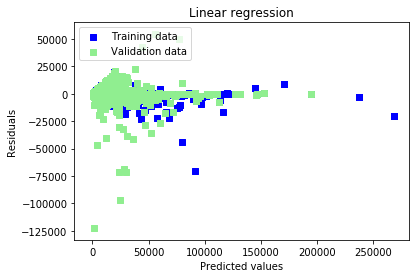

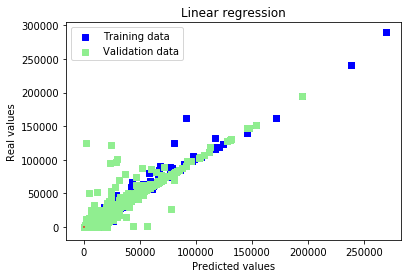

In [212]:
lr = RandomForestRegressor(n_estimators=100)
lr.fit(X_train_, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train_)
y_test_pred = lr.predict(X_test_)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

### Hyper Parameter Tunning using Randomized Search CV[](http://)

In [213]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        
rf_cfl = RandomForestRegressor(n_jobs = -1)

# Number of trees in random forest
n_estimators = [100,200,300,400]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,30,40,50]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

folds = 5
param_comb = 10

random_search = RandomizedSearchCV(rf_cfl,param_distributions=params, n_iter=param_comb, scoring='r2', n_jobs=-1, cv=5, verbose=3, random_state=42)

start_time = timer(None) 
random_search.fit(X, y)
print(random_search.best_params_)
timer(start_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.7min finished


{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}

 Time taken: 0 hours 8 minutes and 49.24 seconds.


In [214]:
random_clf = RandomForestRegressor(n_estimators = 300,min_samples_split=5,min_samples_leaf=2,max_features='sqrt',max_depth=30,bootstrap=True)

random_clf.fit(X_train_,y_train)
y_pred = random_clf.predict(X_test_)
train_pred = random_clf.predict(X_train_)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train,train_pred),
mean_squared_error(y_test,y_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,train_pred),
r2_score(y_test,y_pred)))

MSE train data: 4279447.346, MSE test data: 14716459.166
R2 train data: 0.983, R2 test data: 0.930


### Applying L2 Regularization 

Best alpha : 1.0
Try again for more precision with alphas centered around 1.0
Best alpha : 1.4
Ridge RMSE on Training set : 13061.68000882903
Ridge RMSE on Test set : 11881.542863644661


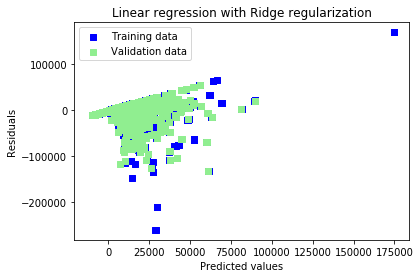

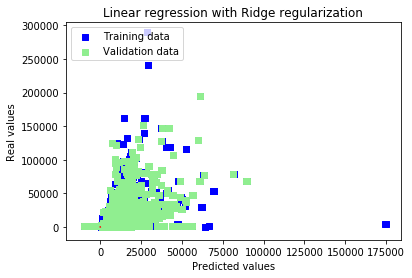

In [215]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train_, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train_)
y_test_rdg = ridge.predict(X_test_)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

### Experimenting with ANNs

In [216]:
def model():    
    model = Sequential()
    model.add(Dense(28,input_dim = 28,activation='relu',kernel_initializer='normal'))
    model.add(Dense(6,activation='tanh',kernel_initializer='normal'))
    model.add(Dense(1,activation = 'linear'))
    model.compile(loss = 'mse',optimizer='adam',metrics=['mse','mae'])
    return model

In [217]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('keras', KerasRegressor(build_fn=model, epochs=100, batch_size=128, verbose=1)))
pipeline = Pipeline(estimators)
pipeline.fit(X_train,y_train)
##kfold = KFold(n_splits=10)
#results = cross_val_score(pipeline, X, y, cv=kfold)
#print("ANN Score: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/100
22692/22692 [==============================] - 0s 19us/step - loss: 331997655.6009 - mse: 331997728.0000 - mae: 9071.2539
Epoch 2/100
22692/22692 [==============================] - 0s 13us/step - loss: 331958905.6711 - mse: 331958816.0000 - mae: 9069.0205
Epoch 3/100
22692/22692 [==============================] - 0s 12us/step - loss: 331933360.3187 - mse: 331933312.0000 - mae: 9067.5723
Epoch 4/100
22692/22692 [==============================] - 0s 12us/step - loss: 331909430.0187 - mse: 331909376.0000 - mae: 9066.2354
Epoch 5/100
22692/22692 [==============================] - 0s 13us/step - loss: 331886119.9027 - mse: 331886080.0000 - mae: 9064.9473
Epoch 6/100
22692/22692 [==============================] - 0s 13us/step - loss: 331863055.2329 - mse: 331863008.0000 - mae: 9063.6689
Epoch 7/100
22692/22692 [==============================] - 0s 13us/step - loss: 331840248.3624 - mse: 331840352.0000 - mae: 9062.4092
Epoch 8/100
22692/22692 [==============================] - 0s 

22692/22692 [==============================] - 0s 13us/step - loss: 330637947.6228 - mse: 330638016.0000 - mae: 8995.9365
Epoch 62/100
22692/22692 [==============================] - 0s 12us/step - loss: 330615804.5591 - mse: 330615808.0000 - mae: 8994.7041
Epoch 63/100
22692/22692 [==============================] - 0s 12us/step - loss: 330593693.2981 - mse: 330593696.0000 - mae: 8993.4775
Epoch 64/100
22692/22692 [==============================] - 0s 12us/step - loss: 330571589.9454 - mse: 330571616.0000 - mae: 8992.2529
Epoch 65/100
22692/22692 [==============================] - 0s 12us/step - loss: 330549451.7497 - mse: 330549440.0000 - mae: 8991.0205
Epoch 66/100
22692/22692 [==============================] - 0s 12us/step - loss: 330527335.7786 - mse: 330527360.0000 - mae: 8989.8018
Epoch 67/100
22692/22692 [==============================] - 0s 13us/step - loss: 330505222.4777 - mse: 330505216.0000 - mae: 8988.5732
Epoch 68/100
22692/22692 [==============================] - 0s 12us/

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('keras',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f79e0023eb8>)],
         verbose=False)

In [218]:
y_pred= pipeline.predict(X_test_)

7564/7564 [==============================] - 0s 6us/step


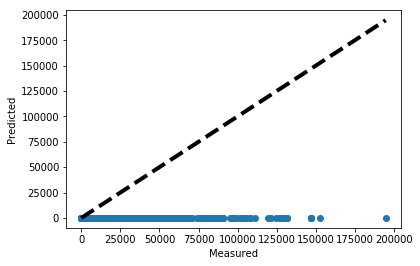

In [219]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Prediction Models with One Hot Encoding

In [220]:
preprocessed_data_with_ohe

,moleculeValues,dosageValues,country,fulfill_via,shipment_mode,product_group,sub_classification,vendor,brand,dosage_form,unit_of_measure_per_pack,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,line_item_insurance_usd,Waiting_Time_days,ScheduleDelivery_Y,ScheduleDelivery_M,ScheduleDelivery_D,delivered_to_client_date_Y,delivered_to_client_date_M,delivered_to_client_date_D,delivery_recorded_date_Y,delivery_recorded_date_M
0,Rapid HIV Antibody Test,300,Côte d'Ivoire,Direct Drop,Air,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,Reveal,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13.000,780.34,47.04,0,2006,6,2,2006,6,2,2006,2
1,Nevirapine,10,Vietnam,Direct Drop,Air,ARV,Pediatric,Aurobindo Pharma Limited,Generic,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358.000,4521.50,47.04,0,2006,11,14,2006,11,14,2006,14
2,HIV 1,300,Côte d'Ivoire,Direct Drop,Air,HRDT,HIV test,Abbott GmbH & Co. KG,Determine,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.000,1653.78,47.04,0,2006,8,27,2006,8,27,2006,27
3,Complete HIV Kit,300,Côte d'Ivoire,Direct Drop,Air,HRDT,HIV test,Abbott GmbH & Co. KG,Determine,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.000,1653.78,47.04,0,2006,8,27,2006,8,27,2006,27
4,Lamivudine,150,Vietnam,Direct Drop,Air,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Generic,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855.000,16007.06,47.04,0,2006,9,1,2006,9,1,2006,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,Zidovudine,300,Zimbabwe,From RDC,Truck,ARV,Adult,SCMS from RDC,Generic,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392.000,1422.09,134.03,29,2015,9,9,2015,8,4,2015,11
30252,Lamivudine,30,Zimbabwe,From RDC,Truck,ARV,Pediatric,SCMS from RDC,Generic,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,1422.205,1422.09,85.82,20,2015,8,31,2015,8,4,2015,11
30253,Lamivudine,60,Zimbabwe,From RDC,Truck,ARV,Pediatric,SCMS from RDC,Generic,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,1422.205,1422.09,85.82,20,2015,8,31,2015,8,4,2015,11
30254,Zidovudine,30,Zimbabwe,From RDC,Truck,ARV,Pediatric,SCMS from RDC,Generic,Chewable/dispersible tablet - FDC,60,36639,72911.61,1.99,0.03,"Cipla, Goa, India",No,1422.205,1422.09,85.82,20,2015,8,31,2015,8,4,2015,11


In [221]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

# Def X and Y
y = np.array(preprocessed_data_with_ohe.freight_cost_usd.tolist())
preprocessed_data_with_ohe= preprocessed_data_with_ohe.drop('freight_cost_usd', 1)
X = preprocessed_data_with_ohe

In [222]:
categorical_features = X.dtypes==object
categorical_cols = X.columns[categorical_features].tolist()

In [224]:
labelenc = LabelEncoder()
X[categorical_cols] = X[categorical_cols].apply(lambda col: labelenc.fit_transform(col))
X[categorical_cols].head(10)

,moleculeValues,dosageValues,country,fulfill_via,shipment_mode,product_group,sub_classification,vendor,brand,dosage_form,manufacturing_site,first_line_designation
0,72,16,9,0,0,3,2,56,33,15,76,1
1,65,1,40,0,0,2,5,13,15,8,11,1
2,40,16,9,0,0,3,2,12,11,15,5,1
3,32,16,9,0,0,3,2,12,11,15,5,1
4,55,8,40,0,0,2,1,64,15,10,79,1
5,75,15,40,0,0,2,1,13,15,0,11,1
6,79,1,28,0,0,2,5,13,15,7,11,1
7,37,11,41,0,0,2,5,42,36,0,54,1
8,65,11,37,0,0,2,1,13,15,10,11,1
9,75,15,28,0,0,2,1,13,15,0,11,0


In [225]:
ohe = OneHotEncoder(categorical_features = categorical_features, sparse=False ) 
X = ohe.fit_transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning:

The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.



In [226]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)

### Model Selection

In [227]:
clfs = []
seed = 3

clfs.append(("LinearRegression", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LinearRegression())])))

clfs.append(("XGB",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBRegressor())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsRegressor())]))) 

clfs.append(("DTR", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeRegressor())]))) 

clfs.append(("RFRegressor", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestRegressor())]))) 

clfs.append(("GBRegressor", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingRegressor(max_features=15, 
                                                                       n_estimators=600))]))) 

clfs.append(("MLP", 
             Pipeline([("Scaler", StandardScaler()),
                       ("MLP Regressor", MLPRegressor())])))


clfs.append(("EXT Regressor",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreeRegressor())])))

scoring = 'r2'
n_folds = 10
msgs = []
results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv=kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    msgs.append(msg)
    print(msg)
    

LinearRegression: -11174282230167434296295424.000000 (+/- 16376114928361529323552768.000000)
XGB: 0.774707 (+/- 0.021278)
KNN: 0.694693 (+/- 0.045936)
DTR: 0.946642 (+/- 0.024778)
RFRegressor: 0.959439 (+/- 0.014460)
GBRegressor: 0.767279 (+/- 0.035442)
MLP: 0.474862 (+/- 0.039111)
EXT Regressor: 0.938432 (+/- 0.022580)


RMSE on Training set : 2921.1368045595827
RMSE on Test set : 5953.329944868693


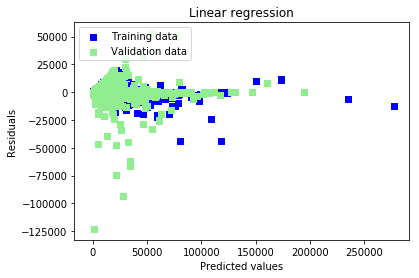

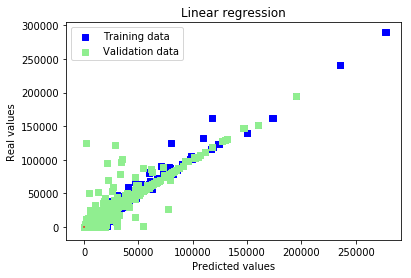

In [228]:
# Linear Regression
lr = RandomForestRegressor(n_estimators=100)
lr.fit(X_train_, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train_)
y_test_pred = lr.predict(X_test_)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

### Improving Model Metrics
> Removing Multicollinear features with VIF's

In [229]:
le_for_vif = LabelEncoder()
for i in range(0,preprocessed_data_with_vif.shape[1]):
    if preprocessed_data_with_vif.dtypes[i]=='object':
        preprocessed_data_with_vif[preprocessed_data_with_vif.columns[i]] = le_for_vif.fit_transform(preprocessed_data_with_vif[preprocessed_data_with_vif.columns[i]])

In [230]:
X_vif = preprocessed_data_with_vif
y_vif = X_vif.pop('freight_cost_usd')
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [231]:
transformer = ReduceVIF()

#X_vif = transformer.fit_transform(X_vif[X_vif.columns[-10:]], y_vif)
X_vif = transformer.fit_transform(X_vif)


X_vif.head()

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.



ReduceVIF fit
ReduceVIF transform
Dropping ScheduleDelivery_Y with vif=3134325605.8823214
Dropping delivery_recorded_date_Y with vif=773075762.8163841
Dropping delivered_to_client_date_Y with vif=167.01111780320926
Dropping product_group with vif=81.09219699089705
Dropping line_item_value with vif=33.56334543138587
Dropping ScheduleDelivery_M with vif=24.9208561739186
Dropping vendor with vif=22.629729504719347
Dropping delivered_to_client_date_D with vif=12.43779736302775
Dropping dosage_form with vif=11.817472659436271
Dropping moleculeValues with vif=10.543040166173869
Dropping dosageValues with vif=7.366162006946023
Dropping ScheduleDelivery_D with vif=6.427430113301104
Dropping country with vif=5.880302329115252
Dropping line_item_quantity with vif=5.605337600783841
Dropping brand with vif=5.05676775035973


,fulfill_via,shipment_mode,sub_classification,unit_of_measure_per_pack,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,line_item_insurance_usd,Waiting_Time_days,delivered_to_client_date_M,delivery_recorded_date_M
0,0.0,0.0,2.0,30.0,29.00,0.97,76.0,1.0,13.0,47.04,0.0,6.0,2.0
1,0.0,0.0,5.0,240.0,6.20,0.03,11.0,1.0,358.0,47.04,0.0,11.0,14.0
2,0.0,0.0,2.0,100.0,80.00,0.80,5.0,1.0,171.0,47.04,0.0,8.0,27.0
3,0.0,0.0,2.0,100.0,80.00,0.80,5.0,1.0,171.0,47.04,0.0,8.0,27.0
4,0.0,0.0,1.0,60.0,3.99,0.07,79.0,1.0,1855.0,47.04,0.0,9.0,1.0


In [232]:
X_train_vif,X_test_vif,y_train_vif,y_test_vif = train_test_split(X_vif,y_vif,random_state=0,test_size=0.20)
scaler_vif = StandardScaler()
X_train_vif = scaler_vif.fit_transform(X_train_vif)
X_test_vif = scaler_vif.transform(X_test_vif)


In [233]:
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
forest.fit(X_train_vif,y_train_vif)
forest_train_pred = forest.predict(X_train_vif)
forest_test_pred = forest.predict(X_test_vif)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train_vif,forest_train_pred),
mean_squared_error(y_test_vif,forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train_vif,forest_train_pred),
r2_score(y_test_vif,forest_test_pred)))
rms = sqrt(mean_squared_error(y_test_vif, forest_test_pred))
print('Root mean Squared Error for Test Data {} '.format(rms))

MSE train data: 1125773.652, MSE test data: 15406002.344
R2 train data: 0.995, R2 test data: 0.935
Root mean Squared Error for Test Data 3925.048068969578 


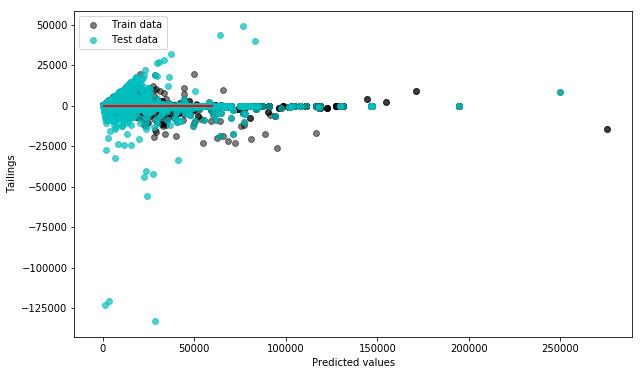

In [234]:
plt.figure(figsize=(10,6))

plt.scatter(forest_train_pred,forest_train_pred - y_train_vif,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(forest_test_pred,forest_test_pred - y_test_vif,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()

## END